In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from dataset.mix_vctk_ljs import CHIMELoader, VCTKLoader
import torch
from audio.sfx import mix_with_snr
from synthesis import Synthesizer
from utils.text import text_to_sequence
from IPython.display import Audio
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, pack_sequence, pad_sequence
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
import hp

Working Under DEBUG Mode ! 
My ID is  CNNRNN_e73


In [3]:
noise_loader = CHIMELoader(hp.part_chime_path, buffered=True)
vctk_loader = VCTKLoader(hp.vctk_wav_path, hp.vctk_text_path)

CHiME :  966
Found VCTK Wave  44083


In [4]:
synthesizer = Synthesizer("./log/checkpoint_126k.pyt")


Initialising Tacotron Model...

Trainable Parameters: 19.806M

Initializing STFT Model...


Loading Weights: "./log/checkpoint_126k.pyt"

+---------------+-------------+------+------+----------+------+------+
| Tacotron(r=3) | Sample Rate | NFFT | NMel | Speakers | SPKD | NOID |
+---------------+-------------+------+------+----------+------+------+
|     126k      |    16000    | 2048 | 128  |   200    |  64  |  8   |
+---------------+-------------+------+------+----------+------+------+
 


In [10]:
from random import randint

In [11]:
def add_rand_noise(wave, noise_loader, dbrange=(5, 25)):
    noise = noise_loader.sample()
    begin = randint(0, len(noise) - len(wave) - 1)
    noise_segment = noise[begin: begin + len(wave)]
    mixed = mix_with_snr(wave, noise_segment, randint(*dbrange))
    return mixed

In [12]:
from random import choice

In [6]:
def inference_batch_wave(synthesizer, waves):
    """
    :param waves: must be a list of FloatTensor on CPU
    :param synthesizer: must be a Synthesizer following API in synthesizer.py
    """
    wave_lengths = torch.as_tensor([len(wave) for wave in waves], dtype=torch.long, device=synthesizer.device)
    waves = pad_sequence(waves, batch_first=True)    
    speaker_latents, noise_latents = synthesizer.batch_inference_speaker_noise(waves, wave_lengths)
    return speaker_latents, noise_latents

In [24]:
def inference_all_noisy(synthesizer, loader, batch_size, noise_loader, add_noise=True):
    """
    :param synthesizer: must be synthesizer with current API
    :param loader: must support len and int sliced indexing, must follow current API
    """
    results = []
    for bdx in tnrange(0, len(loader) // batch_size):
        begin = bdx * batch_size
        end = begin + batch_size
        batch = vctk_loader[begin: end]
        batch = sorted(batch, key=lambda x: len(x[1]), reverse=True)
        texts, waves, speakers, males = zip(*batch)
        # Adding Noise
        if add_noise:
            waves = [add_rand_noise(wave, noise_loader) for wave in waves]
        speaker_latents, noise_latents = inference_batch_wave(synthesizer, waves)
        for speaker, male, speaker_latent, noise_latent in zip(speakers, males, speaker_latents, noise_latents):
            results.append((speaker, male, speaker_latent.cpu(), noise_latent.cpu(), True))
        speaker_latents = None
        noise_latents = None
    return results

In [28]:
noisy = inference_all_noisy(synthesizer, vctk_loader, 128, noise_loader, True)

In [30]:
clean = inference_all_noisy(synthesizer, vctk_loader, 128, None, False)

In [31]:
samples = noisy.extend(clean)

In [36]:
speakers, male, speaker_latents, noise_latents, noisy = zip(*noisy)

In [39]:
torch.save(zip(speakers, male, speaker_latents, noise_latents, noisy), "visualize.pt")

In [10]:
result = list(torch.load("visualize.pt"))

In [18]:
spkid, male, speaker, noise, noisy = zip(*result)

In [15]:
from tsnecuda import TSNE

In [19]:
speaker = torch.stack(speaker)
noise = torch.stack(noise)
speaker_layout = TSNE(perplexity=10.0).fit_transform(speaker.numpy())
noise_layout = TSNE(perplexity=20.0).fit_transform(noise.numpy())

Text(0.5, 1.0, 'Speaker ID Coloring Speaker Latent')

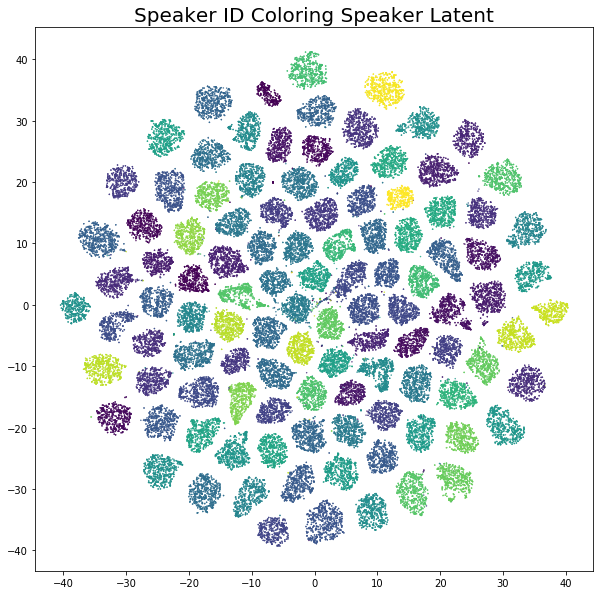

In [70]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(speaker_layout[:, 0], speaker_layout[:, 1], c=spkid, s=0.2)
plt.title("Speaker ID Coloring Speaker Latent", size=20)

Text(0.5, 1.0, 'Augment Label Coloring Speaker Latent')

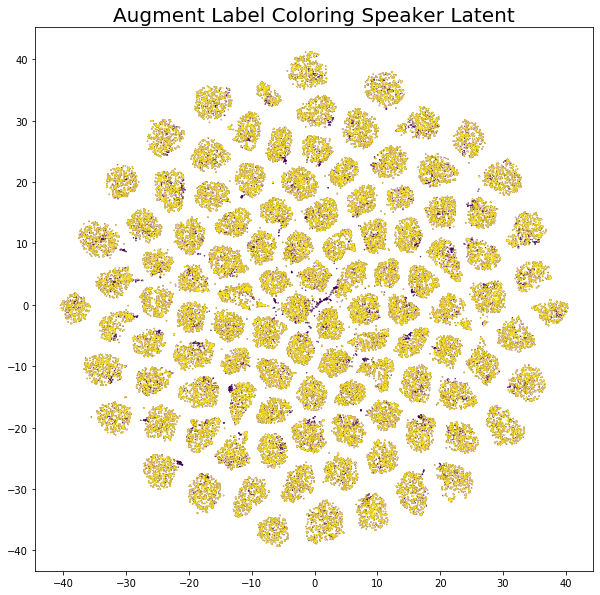

In [68]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(speaker_layout[:, 0], speaker_layout[:, 1], c=[0] * 44032 + [1] * 44032, s=0.2)
plt.title("Augment Label Coloring Speaker Latent", size=20)

Text(0.5, 1.0, 'Speaker Sex Coloring Speaker Latent')

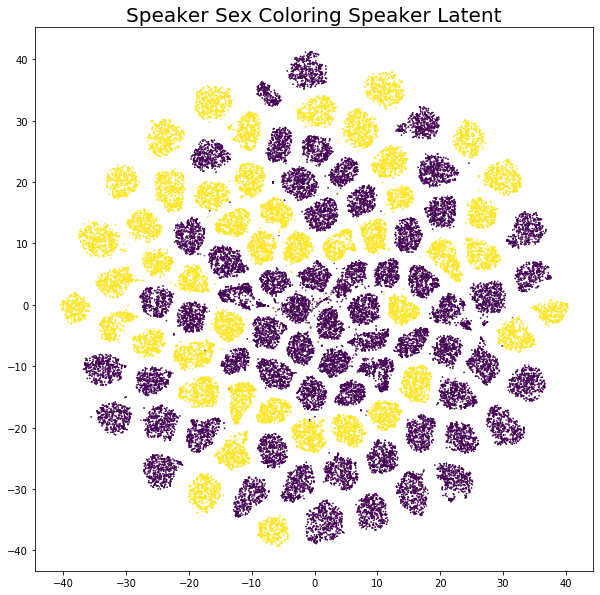

In [71]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(speaker_layout[:, 0], speaker_layout[:, 1], c=male, s=0.2)
plt.title("Speaker Sex Coloring Speaker Latent", size=20)

Text(0.5, 1.0, 'Augment Label Coloring Residual Encoding')

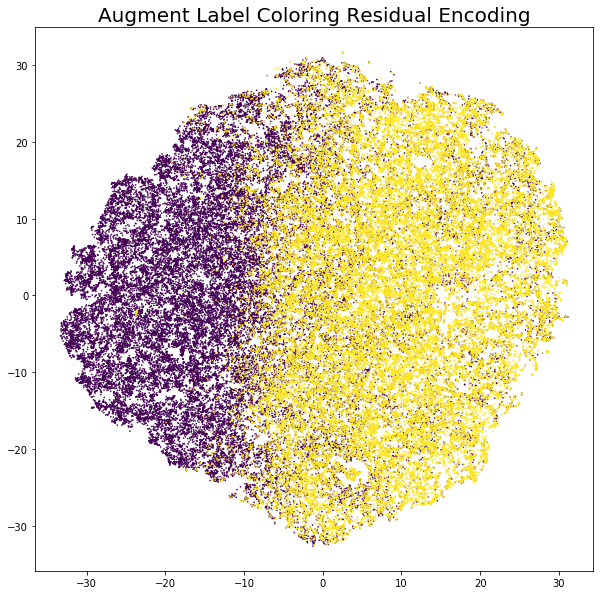

In [73]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(noise_layout[:, 0], noise_layout[:, 1], c=[0] * 44032 + [1] * 44032, s=0.4)
plt.title("Augment Label Coloring Residual Encoding", size=20)

Text(0.5, 1.0, 'Speaker Sex Coloring Residual Latent')

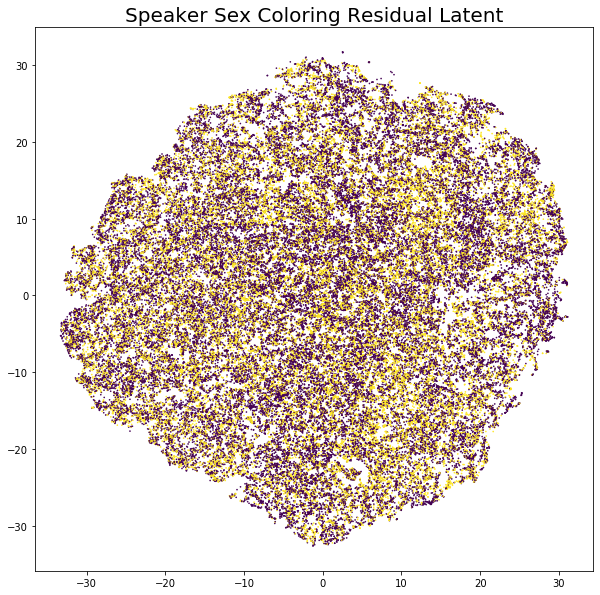

In [74]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(noise_layout[:, 0], noise_layout[:, 1], c=male, s=0.4)
plt.title("Speaker Sex Coloring Residual Latent", size=20)

Text(0.5, 1.0, 'Speaker ID Coloring Residual Latent')

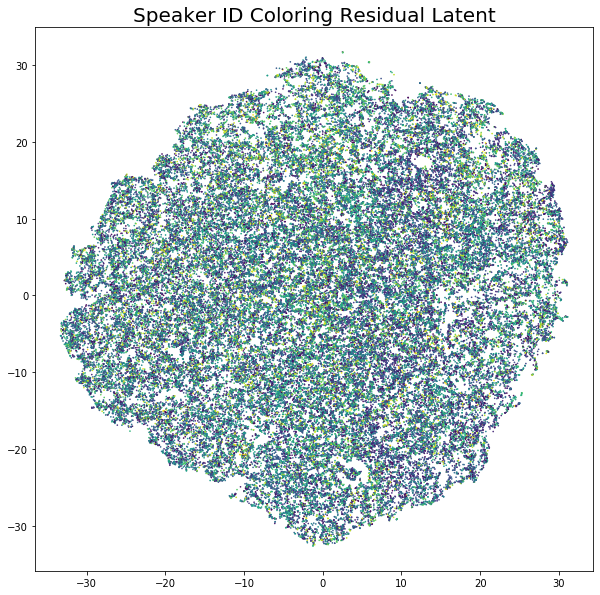

In [75]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(noise_layout[:, 0], noise_layout[:, 1], c=spkid, s=0.4)
plt.title("Speaker ID Coloring Residual Latent", size=20)